# Program run-through

### Section 1:
lisa_glitch_simulation
- how to run
- what it contains
- things that can be adapted and changed
### Section 2:
q-transform
- how to run
- what it contains

imports:

In [49]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal
from gwpy.timeseries import TimeSeriesDict
# from testing import read_out_whitened_data, compare_snr, get_amplitude, level_to_amplitude
from q_transform.analysis import *
from lisa_glitch_simulation.plotting import plot_all_four
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy

PATH_cd = os.getcwd()
PATH_lgs = os.path.join(PATH_cd, 'lisa_glitch_simulation/')
PATH_qfiles = os.path.join(PATH_cd, 'q_transform/q_files/')

In [ ]:
# TODO: beth include ->
# showing how to run lisa_glitch_simulation from the command line 
# -> inc example that can be copy and pasted into the command line
# show how to load the files that come from lisa_glitch_simulation
# plot tdi channels produced, with dashed lines indicating in time of injection

# showing how to run the q-transform on the simulated data
# explain what each file means
# plot the q-scan produced by the tiles from running the q-transform

## Section 1: Glitch Simulation
#### lisa_glitch_simulation

In [21]:
# to run lisa_glitch_simulation to get tdi channels run this from the command line 
# -> make sure to run in simulate_glitch directory or write the path in front of main.py
"""
python main.py --glitch-h5-mg-output testing_glitch_file.h5 --glitch-txt-mg-output testing_glitch_file.txt --tdi-output-file final_tdi_testing.h5 --config-input pipeline_cfg.yml --glitch-config-input glitch_cfg_day.yml
"""


"""
python main.py --glitch-h5-mg-output testing_glitch_file.h5 --glitch-txt-mg-output testing_glitch_file.txt --tdi-output-file final_tdi_testing.h5 --config-input pipeline_cfg.yml --glitch-config-input glitch_cfg_day.yml --clean True
"""
# the above command is this: (written line by line for clarity)
"""
python main.py 
--glitch-h5-mg-output testing_glitch_file.h5 
--glitch-txt-mg-output testing_glitch_file.txt 
--tdi-output-file final_tdi_testing.h5 
--config-input pipeline_cfg.yml 
--glitch-config-input glitch_cfg_day.yml
--clean true
"""
# Notes:
#   - 'main.py' is the file that connects make_glitch.py and inject_glitch.py, running each file consecutively
#   - --glitch-h5-mg-output, --glitch-txt-mg-output are the files that will be outputted from the simulation
#       with --tdi-output-file being the main output file containing the TDI data
#   - --config-input and --glitch-config-input are the input files that set up the configuration of the glitches

''

#### Check

Check in input_output, there should be two files: testing_glitch_file.h5 and testing_glitch_file.txt. The .h5 file contains the measurement and delay information about the glitch and the .txt file contains inputted information of the glitch, like time of injection anf injected amplitude. In final_tdi_outputs directory, there is a file called final_tdi_testing.h5, this contains the TDI information with the injected glitches. It only has TDI X, Y, and Z




In [61]:
# load TDI files
h5_path = PATH_lgs + '/final_tdi_outputs/final_tdi_testing.h5'
obs_tdi = TimeSeriesDict.read(h5_path)
obs_tdi["T"] = (obs_tdi["X"] + obs_tdi["Y"] + obs_tdi["Z"]) / np.sqrt(3.0)
obs_tdi["E"] = (obs_tdi["X"] - 2.0 * obs_tdi["Y"] + obs_tdi["Z"]) / np.sqrt(6.0)
obs_tdi["EV"] = (obs_tdi["Y"] - 2.0 * obs_tdi["Z"] + obs_tdi["X"]) / np.sqrt(6.0)
obs_tdi["A"] = (obs_tdi["Z"] - obs_tdi["X"]) / np.sqrt(2.0)

# load injected times
input_glitches_fname = PATH_lgs + '/input_output/testing_glitch_file.txt'
input_glitches_data = np.genfromtxt(input_glitches_fname)
input_glitch_times = input_glitches_data[1:, 5]
input_glitch_beta = input_glitches_data[1:, 7]
input_glitch_amplitudes = input_glitches_data[1:, -1]
input_glitch_all = {'time': input_glitch_times, 'level': input_glitch_amplitudes, 'beta': input_glitch_beta}

In [62]:
print(obs_tdi["X"])
print(obs_tdi["X"].dt)
print(obs_tdi["X"].dt.value)
print(obs_tdi["X"].value)
print(obs_tdi["X"].times)
print(obs_tdi["X"].shape)

TimeSeries([-0.00000000e+00, -1.58246892e-23, -2.28899248e-22,
            ...,  1.45542929e-21,  5.91571594e-23,
            -0.00000000e+00]
           unit: dimensionless,
           t0: 1.0 s,
           dt: 5.0 s,
           name: None,
           channel: None)
5.0 s
5.0
[-0.00000000e+00 -1.58246892e-23 -2.28899248e-22 ...
  1.45542929e-21  5.91571594e-23 -0.00000000e+00]
[1.0000e+00 6.0000e+00 1.1000e+01 ... 8.6386e+04 8.6391e+04
 8.6396e+04] s
(17280,)


In [44]:
# plt.plot(obs_tdi["X"].times, obs_tdi["X"])
# plt.ylabel("TDI-X")
# plt.xlabel("Time [s]")

# f, psdX =  scipy.signal.welch(obs_tdi["X"], fs=1.0/obs_tdi["X"].dt, window='hann', nperseg=256*256)
# plt.loglog(f, psdX)
# plt.ylabel("PSD X (WOSA)")
# plt.xlabel("Freq [Hz]")

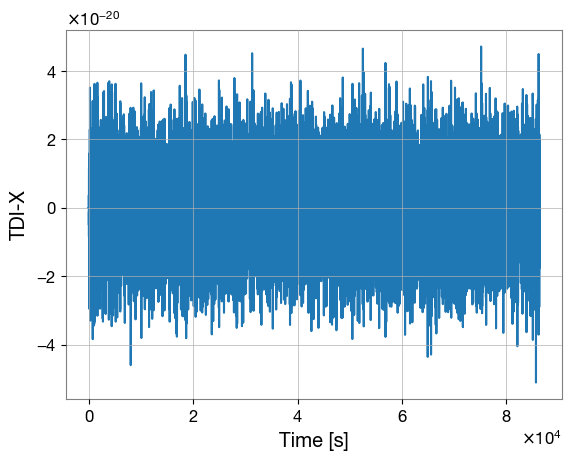

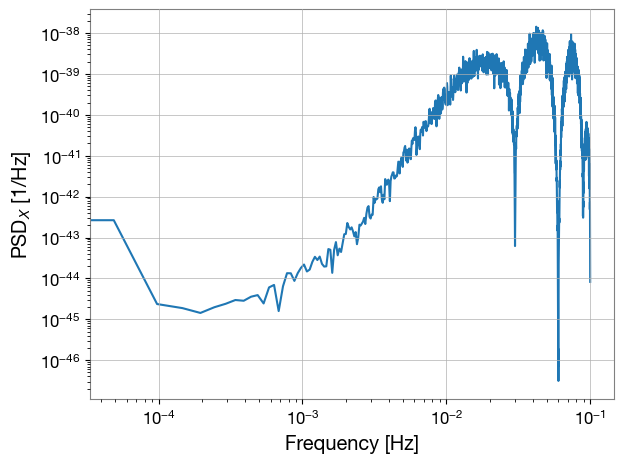

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

# --- time-domain plot -------------------------------------------------------
t   = obs_tdi["X"].times.value          # seconds, now plain ndarray
data = obs_tdi["X"].value               # dimensionless, plain ndarray

plt.figure()
plt.plot(t, data)
plt.xlabel("Time [s]")
plt.ylabel("TDI-X")

# --- PSD with Welch/WOSA ----------------------------------------------------
fs = (1 / obs_tdi["X"].dt).value     # sampling frequency (here 0.2 Hz)

# choose a segment length that is ≤ len(data); e.g. 4096
nper = 4096
f, psdX = sig.welch(data,
                    fs=fs,
                    window='hann',
                    nperseg=nper,          # SciPy will truncate if > len(data)
                    noverlap=nper//2,      # classic WOSA 50 % overlap
                    scaling='density')

plt.figure()
plt.loglog(f, psdX)
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD$_{X}$ [1/Hz]")
plt.tight_layout()


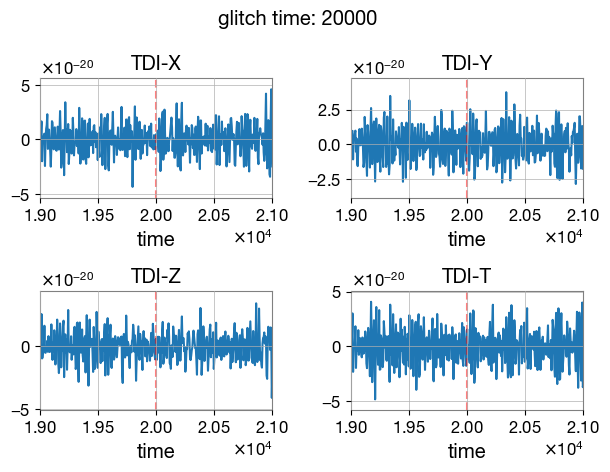

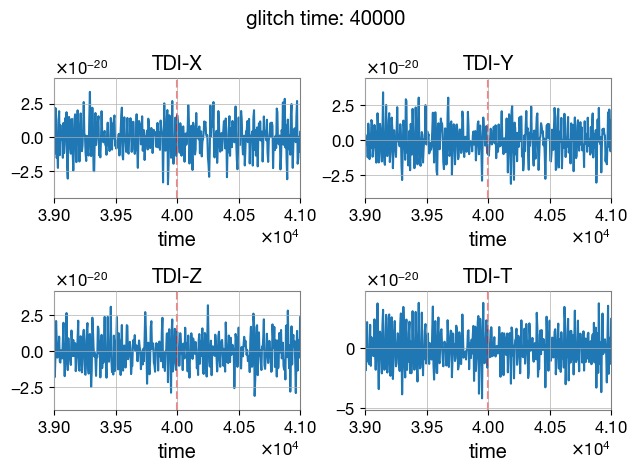

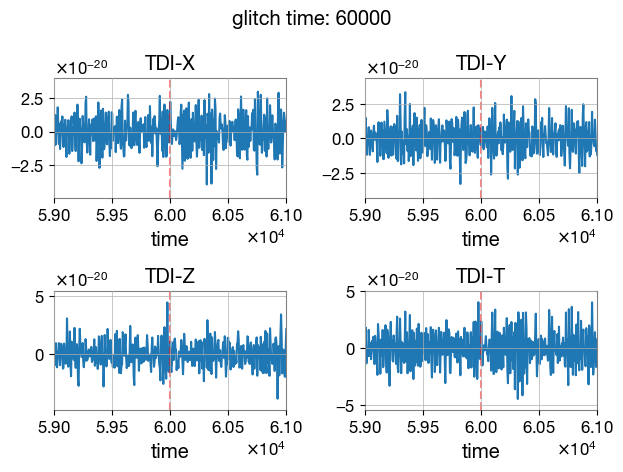

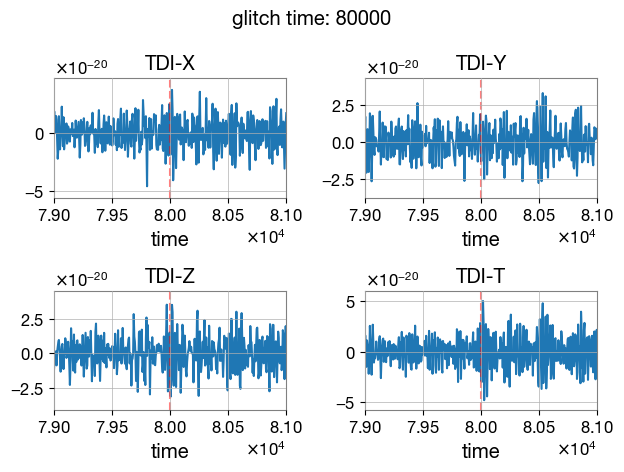

In [57]:
# Plot TDI with glitches
plot_all_four(obs_tdi, glitch_times_inject=input_glitch_times)

## Section 2: Q-transform

#### q_transform and search.py

In [ ]:
# To run the q-transform on the simulated data run this in the command line
# run this command from the bethLISA directory, not the simulate_glitches directory 

"""
python q_transform/search.py --data-file /lisa_glitch_simulation/final_tdi_outputs/final_tdi_testing.h5 --tdi X --qmin 3.3166 --qmax 32 --fmin 0.0001 --fmax 0.1 --snr-thres 5 --mismatch 0.15 --deltat 0 --label tdiX_testing --asd-fftlen 1436 --asd-overlap 718 --wfdur 44
"""

# Notes:
#   - q_transform/search.py is the path to search.py
#   - --data-file is the path to the tdi data that the q-transform will be run on
#   - --tdi which channel we want to check
#   - --qmin minimum q-value
#   - --qmax maximum q-value
#   - --fmin minimum frequency
#   - --fmax maximum frequency
#   - --snr-thres snr threshold, minimum snr to count a tile as a trigger
#   - --mismatch overlap between the tiles
#   - --deltat time separation between clustering tiles
#   - --label output label
#   - --asd-fftlen number of seconds in single FFT
#   - --asd-overlap FFT overlap
#   - --wfdur whitened duration

'\npython q_transform/search.py --data-file /lisa_glitch_simulation/final_tdi_outputs/final_tdi_testing.h5 --tdi X --qmin 3.3166 --qmax 32 --fmin 0.0001 --fmax 0.1 --snr-thres 5 --mismatch 0.15 --deltat 0 --label tdiX_testing --asd-fftlen 1436 --asd-overlap 718 --wfdur 44\n'

#### Check

In q_transform there should be a file called q_files with tdiX triggers in it, with:

- tdiX_testing_all_data_whitened.h5 -> the whitened version of the tdi data
- tdiX_testing_triggers.dat -> clustered triggers
- tdiX_testing_triggers_unclustered.dat -> triggers before clustering process

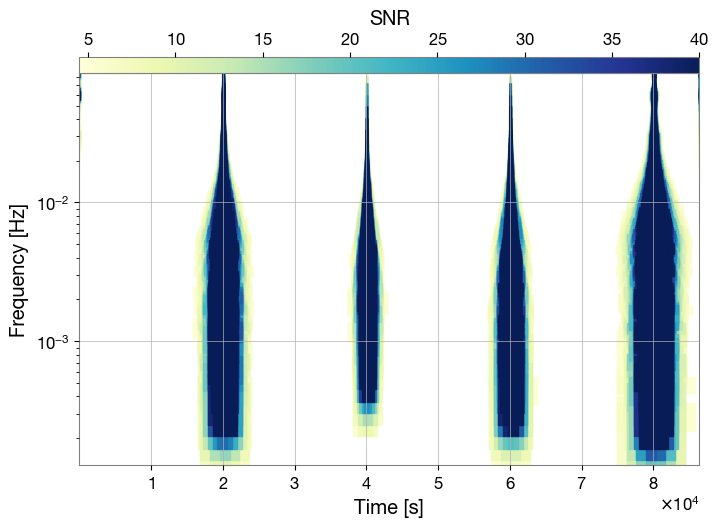

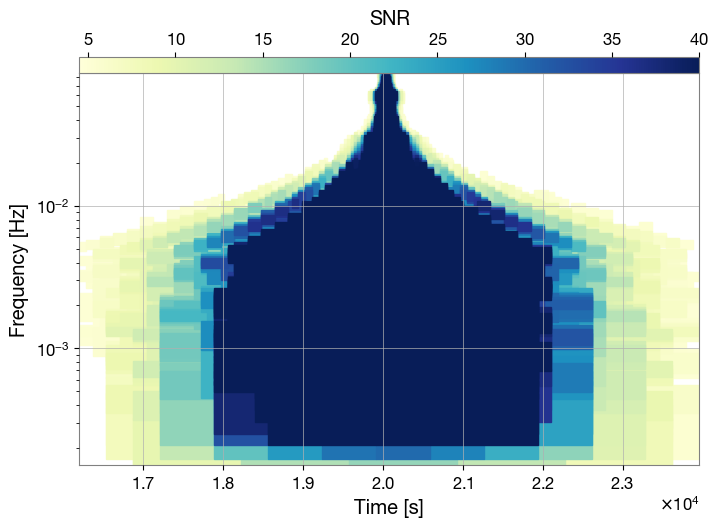

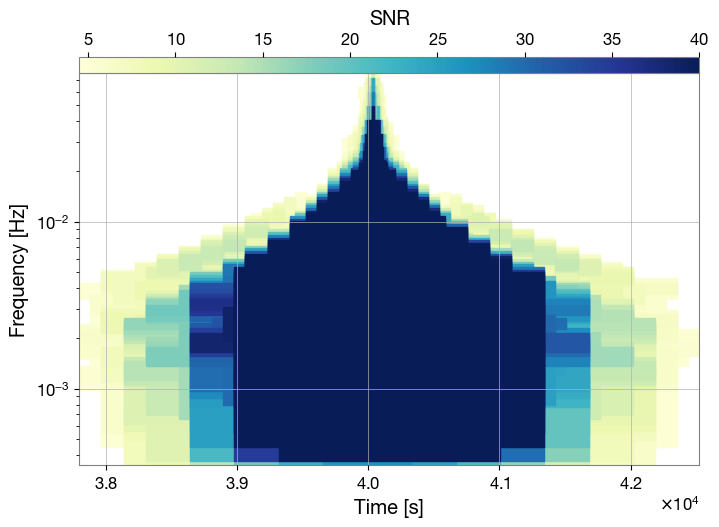

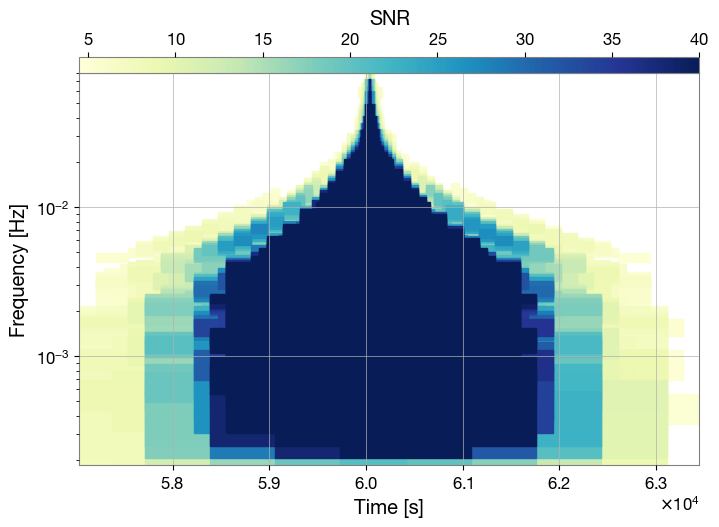

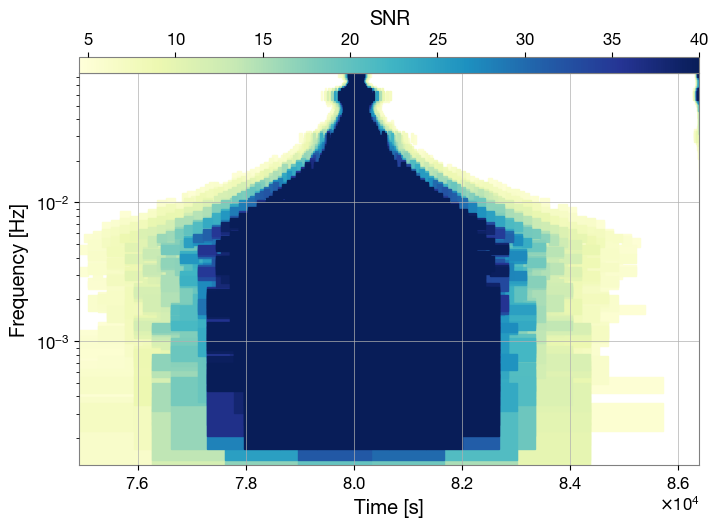

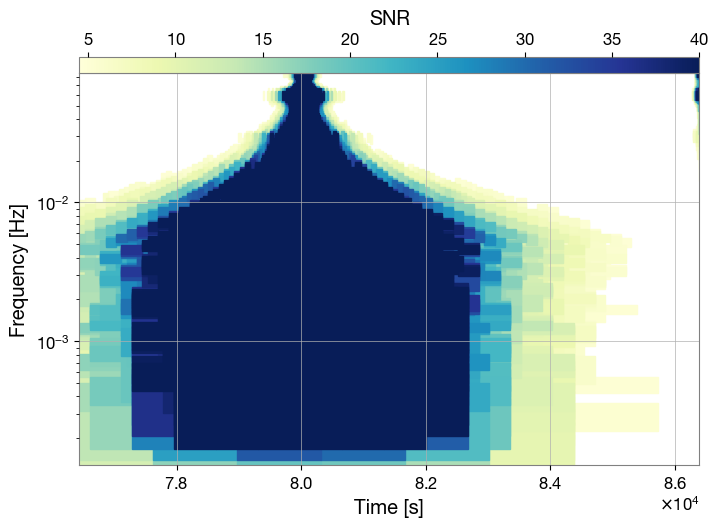

In [12]:
# Plot Q-scan of triggers
fname = 'testing'

# Get unclustered triggers
trigger_file = f'{PATH_qfiles}/tdiX/tdiX_{fname}_triggers_unclustered.dat'
triggers = np.genfromtxt(trigger_file)

# Sort ascending in SNR
triggers = triggers[triggers[:, -1].argsort()]
trigger_times = triggers[:, 0]
trigger_freqs = triggers[:, 1]
trigger_duration = triggers[:, 2]
trigger_bandwidth = triggers[:, 3]
trigger_snr = triggers[:, -1]

plot_all(trigger_times, trigger_freqs, trigger_duration, trigger_bandwidth, trigger_snr, trange=None, frange=None, title='',
         duration_bar=False, bw_bar=False, ax=None, focus_freq=None, focus_time=None, focus_bw=None, focus_dur=None, focus_snr=None)

# Get clustered triggers
cluster_trigger_file = f'{PATH_qfiles}/tdiX/tdiX_{fname}_triggers.dat'
cluster_triggers = np.genfromtxt(cluster_trigger_file)

c_trigger_times = cluster_triggers[:, 0]
c_trigger_freqs = cluster_triggers[:, 1]
c_trigger_duration = cluster_triggers[:, 2]
c_trigger_bandwidth = cluster_triggers[:, 3]
c_trigger_snr = cluster_triggers[:, -1]

for i in range(len(c_trigger_times)):
    focus_trigger = c_trigger_times[i]
    focus_trigger_dur = c_trigger_duration[i]
    focus_trigger_freq = c_trigger_freqs[i]
    focus_trigger_bw = c_trigger_bandwidth[i]
    focus_snr = c_trigger_snr[i]

    time_range = (focus_trigger - 10000, focus_trigger + 10000)

    trigger_times_in_idx = np.where((trigger_times >= time_range[0]) & (trigger_times <= time_range[1]))[0]
    trigger_times_in = trigger_times[trigger_times_in_idx]
    trigger_freqs_in = trigger_freqs[trigger_times_in_idx]
    trigger_duration_in = trigger_duration[trigger_times_in_idx]
    trigger_bandwidth_in = trigger_bandwidth[trigger_times_in_idx]
    trigger_snr_in = trigger_snr[trigger_times_in_idx]

    plot_all(trigger_times_in, trigger_freqs_in, trigger_duration_in, trigger_bandwidth_in, trigger_snr_in, trange=None, frange=None, title='',
             duration_bar=False, bw_bar=False, ax=None, focus_freq=None, focus_time=None, focus_bw=None, focus_dur=None, focus_snr=None)

#### YAY

But, this isn't super realistic so let's create a file with a more realistic set of LISA glitches

Run this in the command line:

In [ ]:
"""
python main.py --glitch-h5-mg-output testing_glitch_file_better.h5 --glitch-txt-mg-output testing_glitch_file_better.txt --tdi-output-file final_tdi_testing_better.h5 --config-input pipeline_cfg.yml --glitch-config-input glitch_cfg_fifth_yr.yml
"""

"""
python main.py 
--glitch-h5-mg-output testing_glitch_file_better.h5 
--glitch-txt-mg-output testing_glitch_file_better.txt 
--tdi-output-file final_tdi_testing_better.h5 
--config-input pipeline_cfg.yml
--glitch-config-input glitch_cfg_fifth_yr.yml
"""

Well that's going to take a min (or few) to finish because it's doing a fifth of a year.

So while that's spinning its wheels, let's look the config file to see what's going on

If you open the file you'll see this:

~~~
t_max: 6307200 s
t_min: 0 s
dt: 5 s
glitch_type: 'Poisson'
amp_type: 'Gaussian'
beta_type: 'Exponential'
glitch_rate: 4
glitch_spacing: 20000
avg_amp: 1e-10
amp_std: 1.5e-11
avg_set_min: 1e-9
avg_set_max: 1e-11
beta_scale: 50
beta_set_min: 0.001
beta_set_max: 100
~~~

Most of these are self-explanatory (hopefully), so let's look the ones potentially less so.

First, glitch_type refers to type of distribution the glitches will have in injection time. The possible entries for this are 'Equal Spacing' and 'Poisson'. If 'Equal Spacing' is chosen the time separation will be given by glitch_spacing, if 'Poisson' is chosen then the Poisson rate is given by glitch_rate (in this case it's given as 4 glitches per day, if this get's changed keep in mind it's per day, also this was picked as it's the same rate as used by the LDC)

Next, amp_type is sort of self-explanatory but just incase, this decides the distribution of the injected amplitudes. There are two choices; 'Gaussian' and 'Set'. 'Gaussian' gives amplitudes from a gaussian distribution with mean of avg_amp and standard deviation of amp_std. 'Set' gives amplitudes evening spaced from avg_set_min to avg_set_max, if they're set to same value then all the glitches would have the same injected amplitude.
        - Note: the injected amplitude doesn't correlate completely to the output amplitude, ie. how it would show in the TDI -> read to README

Finally, beta_type (as we may expect at this point) is the distribution of the injected beta (read README if beta means nothing to you), the options are 'Exponential' and 'Set'. 'Exponential' selects beta from an exponential distribution using beta_scale as the exponential scale. It's chosen as 50 as defaults for now, this was because it gave a similar range to betas from set of glitches from LDC. 'Set' gives evenly spaced betas from beta_set_min to beta_set_max.

Hopefully it's done running now...

... Let's take a look, run this

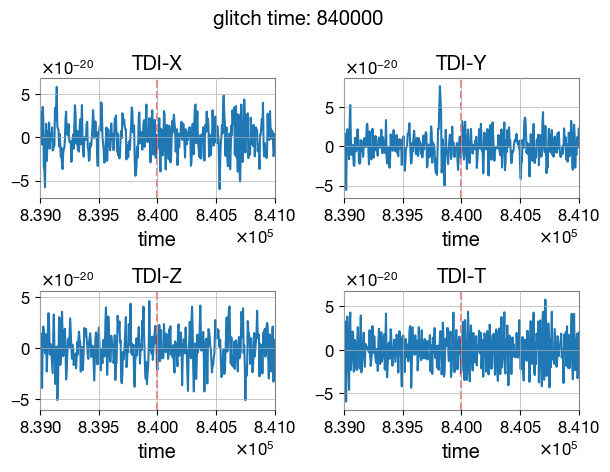

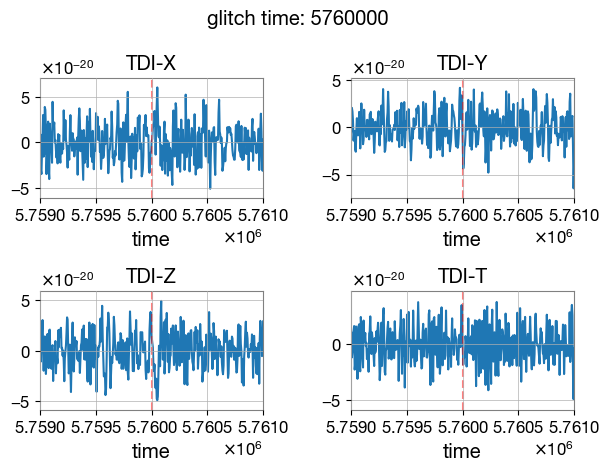

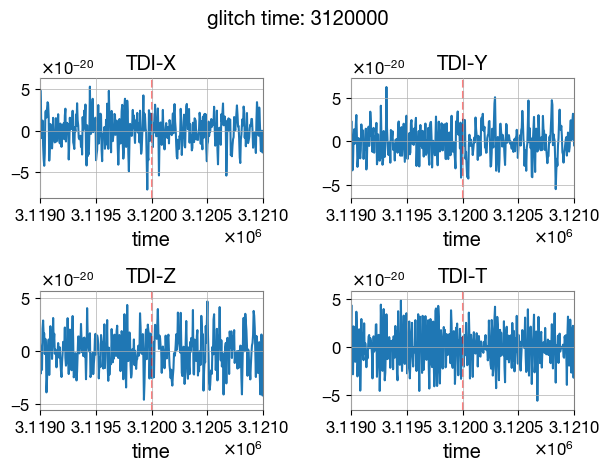

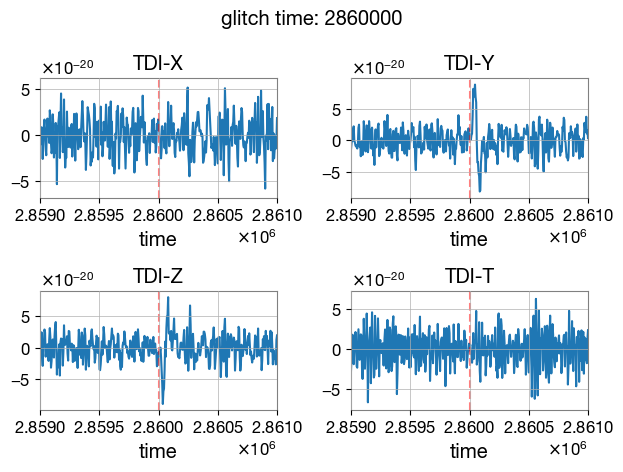

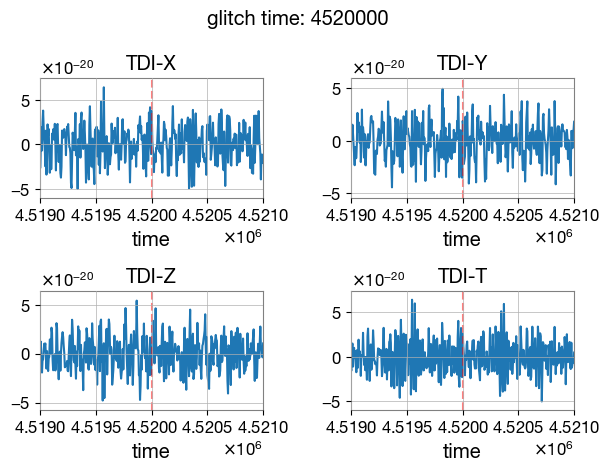

In [13]:
# First we need to load the new files

# load TDI files
h5_path = PATH_lgs + '/final_tdi_outputs/final_tdi_testing_better.h5'
obs_tdi = TimeSeriesDict.read(h5_path)
obs_tdi["T"] = (obs_tdi["X"] + obs_tdi["Y"] + obs_tdi["Z"]) / np.sqrt(3.0)
obs_tdi["E"] = (obs_tdi["X"] - 2.0 * obs_tdi["Y"] + obs_tdi["Z"]) / np.sqrt(6.0)
obs_tdi["EV"] = (obs_tdi["Y"] - 2.0 * obs_tdi["Z"] + obs_tdi["X"]) / np.sqrt(6.0)
obs_tdi["A"] = (obs_tdi["Z"] - obs_tdi["X"]) / np.sqrt(2.0)

# load injected times
input_glitches_fname = PATH_lgs + '/input_output/testing_glitch_file_better.txt'
input_glitches_data = np.genfromtxt(input_glitches_fname)
input_glitch_times = input_glitches_data[1:, 5]
input_glitch_beta = input_glitches_data[1:, 7]
input_glitch_amplitudes = input_glitches_data[1:, -1]
input_glitch_all = {'time': input_glitch_times, 'level': input_glitch_amplitudes, 'beta': input_glitch_beta}

# Randomly pick 5 to plot (cuz we don't want to be here forever)
idx = np.random.randint(0, len(input_glitch_times), size=5)

# Plot TDI with glitches
plot_all_four(obs_tdi, glitch_times_inject=input_glitch_times[idx])

Now it's much clearer to them showing in 2/3 and/or T, this is also just a more realistic example of the amplitudes of glitches that may show in LISA data

Let's take a quick peek at the q-scans

In [ ]:
# To run the q-transform on the simulated data run this in the command line

"""
python q_transform/search.py --data-file /lisa_glitch_simulation/final_tdi_outputs/final_tdi_testing_better.h5 --tdi X --qmin 3.3166 --qmax 32 --fmin 0.0001 --fmax 0.1 --snr-thres 5 --mismatch 0.15 --deltat 0 --label tdiX_testing_better --asd-fftlen 1436 --asd-overlap 718 --wfdur 44
"""

'\npython q_transform/search.py --data-file /lisa_glitch_simulation/final_tdi_outputs/final_tdi_testing_better.h5 --tdi X --qmin 3.3166 --qmax 32 --fmin 0.0001 --fmax 0.1 --snr-thres 5 --mismatch 0.15 --deltat 0 --label tdiX_testing --asd-fftlen 1436 --asd-overlap 718 --wfdur 44\n'

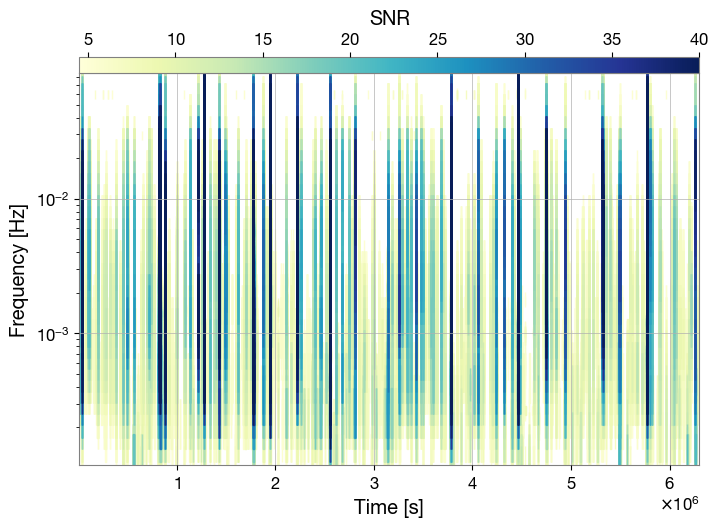

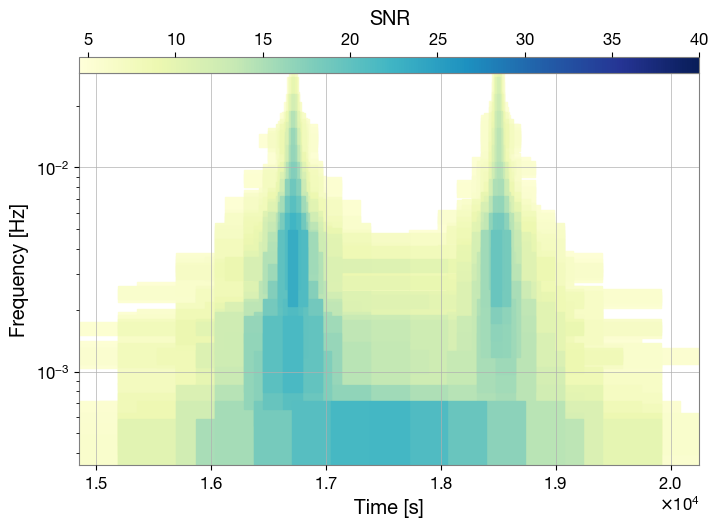

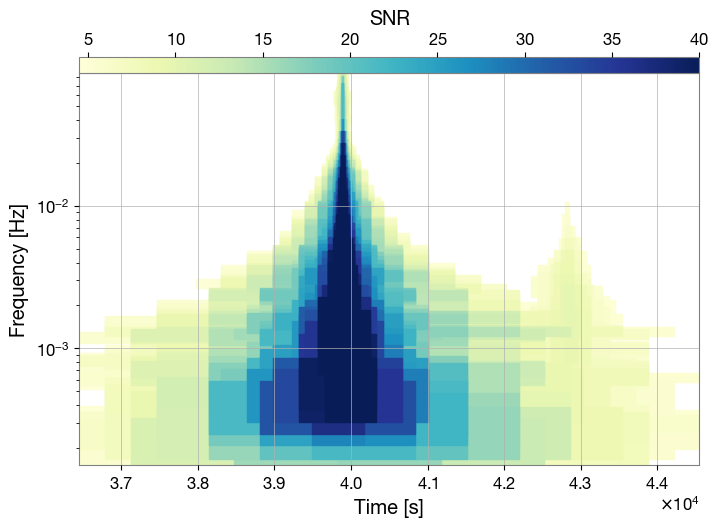

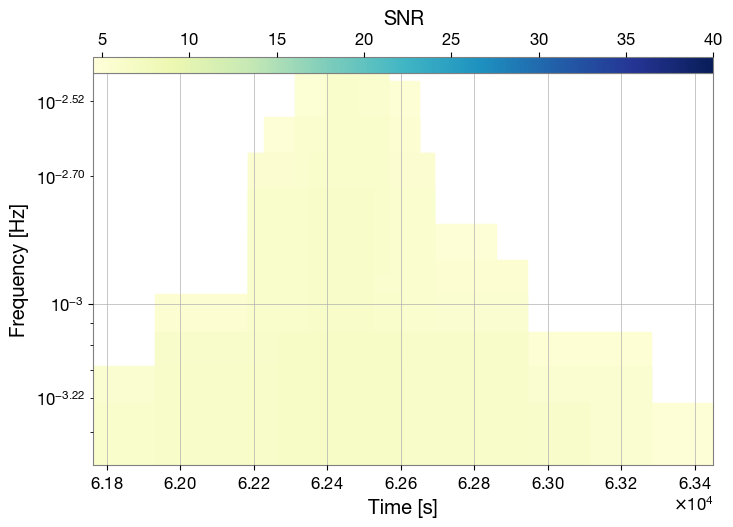

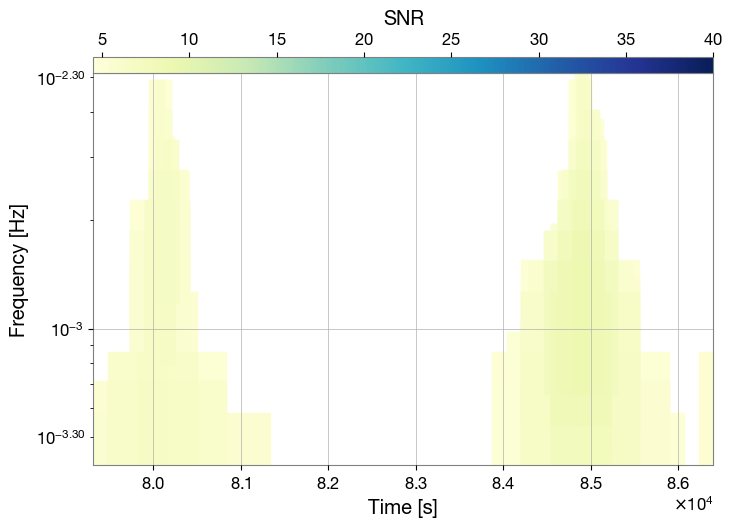

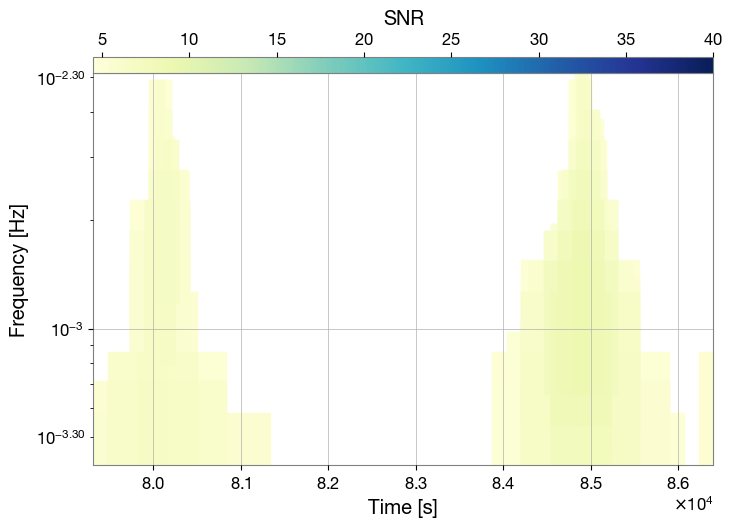

In [14]:
# This code took a couple minutes when running on my machine
# Plot Q-scan of triggers
fname = 'testing_better'

# Get unclustered triggers
trigger_file = f'{PATH_qfiles}/tdiX/tdiX_{fname}_triggers_unclustered.dat'
triggers = np.genfromtxt(trigger_file)

# Sort ascending in SNR
triggers = triggers[triggers[:, -1].argsort()]
trigger_times = triggers[:, 0]
trigger_freqs = triggers[:, 1]
trigger_duration = triggers[:, 2]
trigger_bandwidth = triggers[:, 3]
trigger_snr = triggers[:, -1]

plot_all(trigger_times, trigger_freqs, trigger_duration, trigger_bandwidth, trigger_snr, trange=None, frange=None, title='',
         duration_bar=False, bw_bar=False, ax=None, focus_freq=None, focus_time=None, focus_bw=None, focus_dur=None, focus_snr=None)

# Get clustered triggers
cluster_trigger_file = f'{PATH_qfiles}/tdiX/tdiX_{fname}_triggers.dat'
cluster_triggers = np.genfromtxt(cluster_trigger_file)

c_trigger_times = cluster_triggers[:, 0]
c_trigger_freqs = cluster_triggers[:, 1]
c_trigger_duration = cluster_triggers[:, 2]
c_trigger_bandwidth = cluster_triggers[:, 3]
c_trigger_snr = cluster_triggers[:, -1]

for i in range(5):  # Just show the first 5
    focus_trigger = c_trigger_times[i]
    focus_trigger_dur = c_trigger_duration[i]
    focus_trigger_freq = c_trigger_freqs[i]
    focus_trigger_bw = c_trigger_bandwidth[i]
    focus_snr = c_trigger_snr[i]

    time_range = (focus_trigger - 10000, focus_trigger + 10000)

    trigger_times_in_idx = np.where((trigger_times >= time_range[0]) & (trigger_times <= time_range[1]))[0]
    trigger_times_in = trigger_times[trigger_times_in_idx]
    trigger_freqs_in = trigger_freqs[trigger_times_in_idx]
    trigger_duration_in = trigger_duration[trigger_times_in_idx]
    trigger_bandwidth_in = trigger_bandwidth[trigger_times_in_idx]
    trigger_snr_in = trigger_snr[trigger_times_in_idx]

    plot_all(trigger_times_in, trigger_freqs_in, trigger_duration_in, trigger_bandwidth_in, trigger_snr_in, trange=None, frange=None, title='',
             duration_bar=False, bw_bar=False, ax=None, focus_freq=None, focus_time=None, focus_bw=None, focus_dur=None, focus_snr=None)

### Next Steps

**Note:**
We are back to the small set of glitches, after this we will go through the more realistic set. Go through both, go through one, go through none, you have free will.

The following is what I did with these triggers to check if they could be glitches or not. If they were triggers at the same time in 2/3 channels and/or it showed in channel T, the trigger is counted as a glitch trigger otherwise it is kicked out. This section cane be refined and played around with. For example, one thing I tried was comparing other channels like E with glitch triggers to help kick out any false positives that may have passed the 2/3 and/or T check.

In [ ]:
# Now run these from the command line, to get triggers for all the
"""
python q_transform/search.py --data-file /lisa_glitch_simulation/final_tdi_outputs/final_tdi_testing.h5 --tdi Y --qmin 3.3166 --qmax 32 --fmin 0.0001 --fmax 0.1 --snr-thres 5 --mismatch 0.15 --deltat 0 --label tdiY_testing --asd-fftlen 1436 --asd-overlap 718 --wfdur 44 ; python q_transform/search.py --data-file /lisa_glitch_simulation/final_tdi_outputs/final_tdi_testing.h5 --tdi Z --qmin 3.3166 --qmax 32 --fmin 0.0001 --fmax 0.1 --snr-thres 5 --mismatch 0.15 --deltat 0 --label tdiZ_testing --asd-fftlen 1436 --asd-overlap 718 --wfdur 44 ; python q_transform/search.py --data-file /lisa_glitch_simulation/final_tdi_outputs/final_tdi_testing.h5 --tdi T --qmin 3.3166 --qmax 32 --fmin 0.0001 --fmax 0.1 --snr-thres 5 --mismatch 0.15 --deltat 0 --label tdiT_testing --asd-fftlen 1436 --asd-overlap 718 --wfdur 44 ; python q_transform/search.py --data-file /lisa_glitch_simulation/final_tdi_outputs/final_tdi_testing.h5 --tdi E --qmin 3.3166 --qmax 32 --fmin 0.0001 --fmax 0.1 --snr-thres 5 --mismatch 0.15 --deltat 0 --label tdiE_testing --asd-fftlen 1436 --asd-overlap 718 --wfdur 44 ; python q_transform/search.py --data-file /lisa_glitch_simulation/final_tdi_outputs/final_tdi_testing.h5 --tdi EV --qmin 3.3166 --qmax 32 --fmin 0.0001 --fmax 0.1 --snr-thres 5 --mismatch 0.15 --deltat 0 --label tdiEV_testing --asd-fftlen 1436 --asd-overlap 718 --wfdur 44 ; python q_transform/search.py --data-file /lisa_glitch_simulation/final_tdi_outputs/final_tdi_testing.h5 --tdi A --qmin 3.3166 --qmax 32 --fmin 0.0001 --fmax 0.1 --snr-thres 5 --mismatch 0.15 --deltat 0 --label tdiA_testing --asd-fftlen 1436 --asd-overlap 718 --wfdur 44
"""

'\npython q_transform/search.py --data-file /lisa_glitch_simulation/final_tdi_outputs/final_tdi_testing.h5 --tdi Y --qmin 3.3166 --qmax 32 --fmin 0.0001 --fmax 0.1 --snr-thres 5 --mismatch 0.15 --deltat 0 --label tdiY_testing --asd-fftlen 1436 --asd-overlap 718 --wfdur 44 ; python q_transform/search.py --data-file /lisa_glitch_simulation/final_tdi_outputs/final_tdi_testing.h5 --tdi Z --qmin 3.3166 --qmax 32 --fmin 0.0001 --fmax 0.1 --snr-thres 5 --mismatch 0.15 --deltat 0 --label tdiZ_testing --asd-fftlen 1436 --asd-overlap 718 --wfdur 44 ; python q_transform/search.py --data-file /lisa_glitch_simulation/final_tdi_outputs/final_tdi_testing.h5 --tdi T --qmin 3.3166 --qmax 32 --fmin 0.0001 --fmax 0.1 --snr-thres 5 --mismatch 0.15 --deltat 0 --label tdiT_testing --asd-fftlen 1436 --asd-overlap 718 --wfdur 44 ; python q_transform/search.py --data-file /lisa_glitch_simulation/final_tdi_outputs/final_tdi_testing.h5 --tdi E --qmin 3.3166 --qmax 32 --fmin 0.0001 --fmax 0.1 --snr-thres 5 --mism

Run the 2/3 and/or T detection check. I recommend also looking through the code in analysis to get a better understanding on what's happening.

In [16]:
fname = 'testing'

fname_X = PATH_qfiles + f'/tdiX/tdiX_{fname}_all_data_whitened.h5'
fname_Y = PATH_qfiles + f'/tdiY/tdiY_{fname}_all_data_whitened.h5'
fname_Z = PATH_qfiles + f'/tdiZ/tdiZ_{fname}_all_data_whitened.h5'
fname_T = PATH_qfiles + f'/tdiT/tdiT_{fname}_all_data_whitened.h5'
fname_E = PATH_qfiles + f'/tdiE/tdiE_{fname}_all_data_whitened.h5'
fname_EV = PATH_qfiles + f'/tdiEV/tdiEV_{fname}_all_data_whitened.h5'

# Non-Beth code:
data_white_X  = TimeSeriesDict.read(fname_X )['X']
data_white_Y  = TimeSeriesDict.read(fname_Y )['Y']
data_white_Z  = TimeSeriesDict.read(fname_Z )['Z']
data_white_T  = TimeSeriesDict.read(fname_T )['T']
data_white_E  = TimeSeriesDict.read(fname_E )['E']
data_white_EV = TimeSeriesDict.read(fname_EV)['EV']

# Beth Code: 
# data_white_X = read_out_whitened_data(fname_X)['X']
# data_white_Y = read_out_whitened_data(fname_Y)['Y']
# data_white_Z = read_out_whitened_data(fname_Z)['Z']
# data_white_T = read_out_whitened_data(fname_T)['T']
# data_white_E = read_out_whitened_data(fname_E)['E']
# data_white_EV = read_out_whitened_data(fname_EV)['EV']

all_white_dict = {'X': data_white_X, 'Y': data_white_Y, 'Z': data_white_Z, 'T': data_white_T, 'E': data_white_E, 'EV': data_white_EV}

fnames = [
    f'q_files/tdiX/tdiX_{fname}_triggers.dat',
    f'q_files/tdiY/tdiY_{fname}_triggers.dat',
    f'q_files/tdiZ/tdiZ_{fname}_triggers.dat',
    f'q_files/tdiT/tdiT_{fname}_triggers.dat',
    f'q_files/tdiE/tdiE_{fname}_triggers.dat',
    f'q_files/tdiEV/tdiEV_{fname}_triggers.dat'
]

all_glitch_info = analysis(fname_list=fnames, white_dict=all_white_dict, cutoff=(10**-13), need_amp=False, remove_fp=False, need_false=False, return_just=['T', 'XY', 'XZ', 'YZ', 'E', 'EV'], coincidence_win=1000, inputs=input_glitch_all, h5_path=h5_path, txt_path=input_glitches_fname)

all_matched_glitches = \
    find_glitch_matches(all_glitch_info['XY']['found glitches'], all_glitch_info['XZ']['found glitches'], all_glitch_info['YZ']['found glitches'],
                            all_glitch_info['T']['found glitches'], check_times=True, input_glitches=input_glitch_all)
all_false_glitches = \
    {'XY false': all_glitch_info['XY']['false glitches'], 'XZ false': all_glitch_info['XZ']['false glitches'],
    'YZ false': all_glitch_info['YZ']['false glitches'], 'T false': all_glitch_info['T']['false glitches']}

Finding Amplitudes of found glitches
Remove False Positives (wippy)
How many are real?
xy glitch found:  1 w/ false:  0 kicked out 0 all in 1
xz glitch found:  0 w/ false:  0 kicked out 0 all in 0
yz glitch found:  3 w/ false:  1 kicked out 0 all in 4
t glitch found:  4 w/ false:  0 kicked out 0 all in 4
e glitch found:  4 w/ false:  0 kicked out 0 all in 4
ev glitch found:  4 w/ false:  0 kicked out 0 all in 4


Above shows how many true glitches were found in 2/3 TDI channels, noting which channels they are found in, along with showing true glitches that are found in T, E, and EV. Note that E and EV are included because we were thinking / trying to use them to cut down on false positives and E tends to be sensitive to test mass glitches. This also shows the count of false alarm triggers that are counted as glitches but not actually associated with a real injected glitch.

**Okay** now lets go over the more realistic set of glitches to see how this works

In [ ]:
# Now run these from the command line, to get triggers
"""
python q_transform/search.py --data-file /lisa_glitch_simulation/final_tdi_outputs/final_tdi_testing_better.h5 --tdi Y --qmin 3.3166 --qmax 32 --fmin 0.0001 --fmax 0.1 --snr-thres 5 --mismatch 0.15 --deltat 0 --label tdiY_testing_better --asd-fftlen 1436 --asd-overlap 718 --wfdur 44 ; python q_transform/search.py --data-file /lisa_glitch_simulation/final_tdi_outputs/final_tdi_testing_better.h5 --tdi Z --qmin 3.3166 --qmax 32 --fmin 0.0001 --fmax 0.1 --snr-thres 5 --mismatch 0.15 --deltat 0 --label tdiZ_testing_better --asd-fftlen 1436 --asd-overlap 718 --wfdur 44 ; python q_transform/search.py --data-file /lisa_glitch_simulation/final_tdi_outputs/final_tdi_testing_better.h5 --tdi T --qmin 3.3166 --qmax 32 --fmin 0.0001 --fmax 0.1 --snr-thres 5 --mismatch 0.15 --deltat 0 --label tdiT_testing_better --asd-fftlen 1436 --asd-overlap 718 --wfdur 44 ; python q_transform/search.py --data-file /lisa_glitch_simulation/final_tdi_outputs/final_tdi_testing_better.h5 --tdi E --qmin 3.3166 --qmax 32 --fmin 0.0001 --fmax 0.1 --snr-thres 5 --mismatch 0.15 --deltat 0 --label tdiE_testing_better --asd-fftlen 1436 --asd-overlap 718 --wfdur 44 ; python q_transform/search.py --data-file /lisa_glitch_simulation/final_tdi_outputs/final_tdi_testing_better.h5 --tdi EV --qmin 3.3166 --qmax 32 --fmin 0.0001 --fmax 0.1 --snr-thres 5 --mismatch 0.15 --deltat 0 --label tdiEV_testing_better --asd-fftlen 1436 --asd-overlap 718 --wfdur 44 ; python q_transform/search.py --data-file /lisa_glitch_simulation/final_tdi_outputs/final_tdi_testing_better.h5 --tdi A --qmin 3.3166 --qmax 32 --fmin 0.0001 --fmax 0.1 --snr-thres 5 --mismatch 0.15 --deltat 0 --label tdiA_testing_better --asd-fftlen 1436 --asd-overlap 718 --wfdur 44
"""

In [20]:
# And now run this
fname = 'testing_better'

fname_X = PATH_qfiles + f'/tdiX/tdiX_{fname}_all_data_whitened.h5'
fname_Y = PATH_qfiles + f'/tdiY/tdiY_{fname}_all_data_whitened.h5'
fname_Z = PATH_qfiles + f'/tdiZ/tdiZ_{fname}_all_data_whitened.h5'
fname_T = PATH_qfiles + f'/tdiT/tdiT_{fname}_all_data_whitened.h5'
fname_E = PATH_qfiles + f'/tdiE/tdiE_{fname}_all_data_whitened.h5'
fname_EV = PATH_qfiles + f'/tdiEV/tdiEV_{fname}_all_data_whitened.h5'

# Non-Beth code:
data_white_X  = TimeSeriesDict.read(fname_X )['X']
data_white_Y  = TimeSeriesDict.read(fname_Y )['Y']
data_white_Z  = TimeSeriesDict.read(fname_Z )['Z']
data_white_T  = TimeSeriesDict.read(fname_T )['T']
data_white_E  = TimeSeriesDict.read(fname_E )['E']
data_white_EV = TimeSeriesDict.read(fname_EV)['EV']

# Beth code: 
# data_white_X = read_out_whitened_data(fname_X)['X']
# data_white_Y = read_out_whitened_data(fname_Y)['Y']
# data_white_Z = read_out_whitened_data(fname_Z)['Z']
# data_white_T = read_out_whitened_data(fname_T)['T']
# data_white_E = read_out_whitened_data(fname_E)['E']
# data_white_EV = read_out_whitened_data(fname_EV)['EV']

all_white_dict = {'X': data_white_X, 'Y': data_white_Y, 'Z': data_white_Z, 'T': data_white_T, 'E': data_white_E, 'EV': data_white_EV}

fnames = [
    f'q_files/tdiX/tdiX_{fname}_triggers.dat',
    f'q_files/tdiY/tdiY_{fname}_triggers.dat',
    f'q_files/tdiZ/tdiZ_{fname}_triggers.dat',
    f'q_files/tdiT/tdiT_{fname}_triggers.dat',
    f'q_files/tdiE/tdiE_{fname}_triggers.dat',
    f'q_files/tdiEV/tdiEV_{fname}_triggers.dat'
]

all_glitch_info = analysis(fname_list=fnames, white_dict=all_white_dict, cutoff=(10**-13), need_amp=False, remove_fp=False, need_false=False, return_just=['T', 'XY', 'XZ', 'YZ', 'E', 'EV'], coincidence_win=1000, inputs=input_glitch_all, h5_path=h5_path, txt_path=input_glitches_fname)

all_matched_glitches = \
    find_glitch_matches(all_glitch_info['XY']['found glitches'], all_glitch_info['XZ']['found glitches'], all_glitch_info['YZ']['found glitches'],
                            all_glitch_info['T']['found glitches'], check_times=True, input_glitches=input_glitch_all)
all_false_glitches = \
    {'XY false': all_glitch_info['XY']['false glitches'], 'XZ false': all_glitch_info['XZ']['false glitches'],
    'YZ false': all_glitch_info['YZ']['false glitches'], 'T false': all_glitch_info['T']['false glitches']}

Finding Amplitudes of found glitches
Remove False Positives (wippy)
How many are real?
xy glitch found:  48 w/ false:  42 kicked out 0 all in 90
xz glitch found:  38 w/ false:  48 kicked out 0 all in 86
yz glitch found:  46 w/ false:  70 kicked out 0 all in 116
t glitch found:  165 w/ false:  328 kicked out 0 all in 493
e glitch found:  184 w/ false:  241 kicked out 0 all in 425
ev glitch found:  162 w/ false:  247 kicked out 0 all in 409
